In [1]:
import pandas as pd
import networkx as nx

from preprocess import load_movielens_data, create_bipartite_graph

datapath = "../data/ml-100k"

rating, movies, users = load_movielens_data(datapath,dataset_type="100K")

user_movie_graph = create_bipartite_graph(rating)

Graph created with 2625 nodes and 100000 edges.


In [2]:
def perform_random_walks(graph, start_node, walk_length=3, num_walks=None):
    """
    Perform random walks from the start node.

    Parameters:
    - graph: NetworkX graph (bipartite with user and movie nodes).
    - start_node: Node to start the random walks.
    - walk_length: Length of each random walk.
    - num_walks: Number of random walks to perform (default is total edges // 3).

    Returns:
    - movie_visits: Dictionary with movie nodes as keys and visit counts as values.
    """
    # Determine number of walks
    if num_walks is None:
        num_walks = graph.number_of_nodes() // 3

    # Initialize movie visit counts
    movie_visits = defaultdict(int)

    # Perform random walks
    for _ in range(num_walks):
        current_node = start_node
        for _ in range(walk_length):
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:
                break
            weights = [graph[current_node][neighbor].get("weight", 1) for neighbor in neighbors]
            probabilities = np.array(weights) / sum(weights)
            
            # Choose neighbor based on edge weights
            current_node = np.random.choice(neighbors, p=probabilities)
            if graph.nodes[current_node].get("bipartite") == 1:  # Movie nodes
                movie_visits[current_node] += 1
    return movie_visits


def rank_movies_with_penalty(graph, movie_visits, walk_length=3, penalty_type="b", total_walks=25):
    """
    Rank movies based on visit counts and penalties for missed visits in random walks.

    Parameters:
    - graph: NetworkX graph (bipartite with user and movie nodes).
    - movie_visits: Dictionary with movie nodes as keys and visit counts as values.
    - walk_length: Length of the random walks.
    - penalty_type: Penalty type ('a', 'b', or 'c').
    - total_walks: Total number of random walks performed.

    Returns:
    - sorted_movies: List of visited movies sorted by their scores (visits minus penalties).
    """
    all_movies = [node for node, data in graph.nodes(data=True) if data.get("bipartite") == 1]
    visited_movies = set(movie_visits.keys())
    unvisited_movies = set(all_movies) - visited_movies
    
    # Estimate m̂ (number of edges in the subgraph within `walk_length` steps)
    bfs_edges = sum(1 for _ in nx.bfs_edges(graph, source=list(graph.nodes)[0], depth_limit=walk_length + 1))
    m_hat = bfs_edges  # Estimated number of edges

    # Prepare scores for visited movies only
    movie_scores = {}

    for movie, visited_times in movie_visits.items():
        # Calculate penalty based on unvisited walks
        unvisited_walks = total_walks - visited_times
        penalty = 0

        if penalty_type == "a":
            penalty = m_hat
        elif penalty_type == "b":
            degree = graph.degree[movie]
            penalty = (2 * m_hat) / degree if degree > 0 else 2 * m_hat  # Handle zero-degree cases
        elif penalty_type == "c":
            penalty = walk_length

        # Calculate the score: visits - penalty
        score = visited_times - (unvisited_walks * penalty)
        movie_scores[movie] = score

    # Sort visited movies by score in descending order
    sorted_movies = sorted(movie_scores.items(), key=lambda x: x[1],reverse=True)
    return sorted_movies

In [3]:
def calculate_correctly_placed_pairs(recommendations, hidden_movies):
    """
    Calculate accuracy based on correctly placed pairs.

    Parameters:
    - recommendations: List of tuples (movie, score) sorted by scores (output of rank_movies_with_penalty).
    - hidden_movies: Set of ground truth hidden movies.

    Returns:
    - accuracy: Fraction of correctly placed pairs.
    """
    # Extract movie rankings from recommendations
    recommended_ranks = {movie: rank for rank, (movie, _) in enumerate(recommendations)}

    # Separate hidden and non-hidden movies
    hidden_movie_ranks = {movie: recommended_ranks[movie] for movie in hidden_movies if movie in recommended_ranks}
    non_hidden_movie_ranks = {movie: recommended_ranks[movie] for movie in recommended_ranks if movie not in hidden_movies}

    # Initialize pair counts
    correct_pairs = 0
    total_pairs = 0

    # Compare all pairs of (hidden, non-hidden)
    for hidden_movie, hidden_rank in hidden_movie_ranks.items():
        for non_hidden_movie, non_hidden_rank in non_hidden_movie_ranks.items():
            # A pair is correctly placed if the hidden movie is ranked higher (lower rank value)
            if hidden_rank < non_hidden_rank:
                correct_pairs += 1
            total_pairs += 1

    # Avoid division by zero
    accuracy = (correct_pairs / total_pairs) if total_pairs > 0 else 0
    return accuracy


def calculate_top_k_accuracy(recommendations, hidden_movies, total_movies, k=10):
    """
    Calculate Top-K accuracy for recommendations based on a percentage.

    Parameters:
    - recommendations: List of tuples (movie, score) sorted by scores (output of rank_movies_with_penalty).
    - hidden_movies: Set of ground truth movies.
    - total_movies: Total number of movies in the dataset.
    - k: Percentage of top recommendations to consider (e.g., k=10 for top 10%).

    Returns:
    - accuracy: Fraction of top-K recommendations present in hidden_movies.
    """
    # Calculate the number of movies to consider based on percentage
    top_k_count = k * len(movies) // 100  # Ensure at least 1 movie is considered

    # Get the top-K recommended movies
    top_k_recommendations = [movie for movie, _ in recommendations[:top_k_count]]

    # Calculate intersection with hidden movies
    correct_recommendations = set(top_k_recommendations) & hidden_movies

    # Compute accuracy
    accuracy = len(correct_recommendations) / top_k_count
    return accuracy


def calculate_recall_at_k(recommendations, hidden_movies, k=10):
    """
    Calculate Recall@k for recommendations, adjusted by total relevant movies in the dataset.

    Parameters:
    - recommendations: List of tuples (movie, score) sorted by scores (output of rank_movies_with_penalty).
    - hidden_movies: Set of ground truth hidden movies for the user.
    - total_movies: Total number of movies in the dataset.
    - k: Percentage of top recommendations to consider (e.g., k=10 for top 10%).
    - total_relevant_movies: Total number of relevant movies in the dataset (or for the user).

    Returns:
    - recall: Fraction of relevant items retrieved in the top-k recommendations.
    """
    # Calculate the number of movies to consider based on percentage
    top_k_count = k * len(movies) // 100  # Ensure at least 1 movie is considered

    # Get the top-K recommended movies
    top_k_recommendations = [movie for movie, _ in recommendations[:top_k_count]]

    # Calculate the number of relevant movies in the top-K recommendations
    relevant_movies = set(top_k_recommendations) & hidden_movies

    # If the total number of relevant movies is not provided, assume it's the length of hidden_movies
    total_relevant_movies = len(hidden_movies)

    # Calculate Recall
    recall = len(relevant_movies) / len(hidden_movies)
    return recall

In [4]:
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import random

def evaluate_recommender(graph, walk_length=3,num_walks=None ,penalty_type="a", k=10):
    """
    Evaluate the recommender system using random walks and penalties.

    Parameters:
    - graph: Bipartite graph.
    - walk_length: Length of each random walk.
    - penalty_type: Type of penalty for unvisited movies.
    - k: Number of top recommendations to consider.

    Returns:
    - avg_top_k_accuracy: Average Top-K accuracy across users.
    - avg_pair_accuracy: Average pairwise accuracy across users.
    """
    users = [node for node, data in graph.nodes(data=True) if data.get("bipartite") == 0]
    avg_top_k_accuracy = 0
    avg_pair_accuracy = 0
    avg_recall_accuracy = 0
    num_users = 0
    results = []

    if num_walks == None :
        num_walks = len(users)//walk_length
    
    for user in users:
        # Get movies watched by user
        watched_movies = set(neighbor for neighbor in graph.neighbors(user) if graph.nodes[neighbor].get("bipartite") == 1)
        if len(watched_movies) > 10:
            num_users += 1
            print(f"\rWorking on: {user}", end="")
            # Split movies into training and hidden sets
            training_movies = set(random.sample(sorted(watched_movies), min(10,2*(len(watched_movies))//3)))
            hidden_movies = watched_movies - training_movies
            #print(len(training_movies), len(hidden_movies), training_movies, hidden_movies,sep='\n')

            # Create temporary graph with training movies only
            temp_graph = graph.copy()
            for movie in hidden_movies:
                temp_graph.remove_edge(user, movie)
            
            #print(num_walks)
            # Perform random walks and rank movies
            movie_visits = perform_random_walks(temp_graph, start_node=user, walk_length=walk_length, num_walks=num_walks)
            recommendations = rank_movies_with_penalty(temp_graph, movie_visits, walk_length=walk_length, penalty_type=penalty_type,
                                                       total_walks=num_walks)
            
            # Calculate accuracy metrics
            top_k_accuracy = calculate_top_k_accuracy(recommendations, hidden_movies, k)
            pair_accuracy = calculate_correctly_placed_pairs(recommendations, {movie: idx for idx, movie in enumerate(hidden_movies)})
            recall_accuracy = calculate_recall_at_k(recommendations, hidden_movies,k)
            
            avg_top_k_accuracy += top_k_accuracy
            avg_pair_accuracy += pair_accuracy
            avg_recall_accuracy += recall_accuracy
            results.append({
                "user": user,
                "top_k_accuracy": top_k_accuracy,
                "pair_accuracy": pair_accuracy,
                "recall_accuracy":recall_accuracy
            })
            
    # Average the accuracies
    avg_top_k_accuracy /= num_users
    avg_pair_accuracy /= num_users
    avg_recall_accuracy /= num_users
    return avg_top_k_accuracy, avg_pair_accuracy, avg_recall_accuracy, results



In [5]:
import pandas as pd
def save_result(avg_top_k_accuracy, avg_pair_accuracy, avg_recall_accuracy, results ,name=""):
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Add overall metrics to the DataFrame
    results_df['avg_top_k_accuracy'] = avg_top_k_accuracy
    results_df['avg_pair_accuracy'] = avg_pair_accuracy
    results_df['avg_recall_accuracy'] = avg_recall_accuracy
    
    # Save to CSV
    results_df.to_csv(f"../evaluated_data/evaluation_results{name}.csv", index=False)
    print(f"Results saved to evaluation_results{name}.csv")


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(avg_top_k_accuracy, avg_pair_accuracy, avg_recall_accuracy, results):
    """
    Visualize the accuracy results.

    Parameters:
    - avg_top_k_accuracy: Average Top-K accuracy across users.
    - avg_pair_accuracy: Average pairwise accuracy across users.
    - avg_recall_accuracy: Average recall accuracy across users.
    - results: Per-user metrics.
    """
    # Bar chart of per-user accuracies
    users = [result["user"] for result in results]
    top_k_accuracies = [result["top_k_accuracy"] for result in results]
    pair_accuracies = [result["pair_accuracy"] for result in results]
    recall_accuracies = [result["recall_accuracy"] for result in results]

    x = np.arange(len(users))  # User indices

    plt.figure(figsize=(14, 7))
    plt.bar(x - 0.3, top_k_accuracies, width=0.6, label="Top-K Accuracy", color="skyblue")
    plt.bar(x, pair_accuracies, width=0.6, label="Pairwise Accuracy", color="orange")
    plt.bar(x + 0.3, recall_accuracies, width=0.6, label="Recall Accuracy", color="green")

    # Add lines for the average accuracies
    plt.axhline(y=avg_top_k_accuracy, color='blue', linestyle='--', label=f"Avg Top-K Accuracy: {avg_top_k_accuracy:.4f}")
    plt.axhline(y=avg_pair_accuracy, color='orange', linestyle='--', label=f"Avg Pairwise Accuracy: {avg_pair_accuracy:.4f}")
    plt.axhline(y=avg_recall_accuracy, color='green', linestyle='--', label=f"Avg Recall Accuracy: {avg_recall_accuracy:.4f}")

    # Customize plot
    plt.xlabel("Users")
    plt.ylabel("Accuracy")
    plt.title("Per-User Accuracy Metrics")
    #plt.xticks(x, [f"User {i+1}" for i in range(len(users))], rotation=90)  # Show "User 1", "User 2", etc.
    plt.legend(loc="upper left")  # Place the legend in the top left corner
    plt.tight_layout()
    plt.show()

    # Overall averages (printed in the console)
    print(f"Average Top-K Accuracy: {avg_top_k_accuracy:.4f}")
    print(f"Average Pairwise Accuracy: {avg_pair_accuracy:.4f}")
    print(f"Average Recall Accuracy: {avg_recall_accuracy:.4f}")



In [7]:
avg_top_k_accuracy3, avg_pair_accuracy3,avg_recall_accuracy3 , results3 = evaluate_recommender(graph=user_movie_graph,
                                                                                           walk_length=3,
                                                                                           penalty_type="b",
                                                                                           k=10)

Working on: user_941

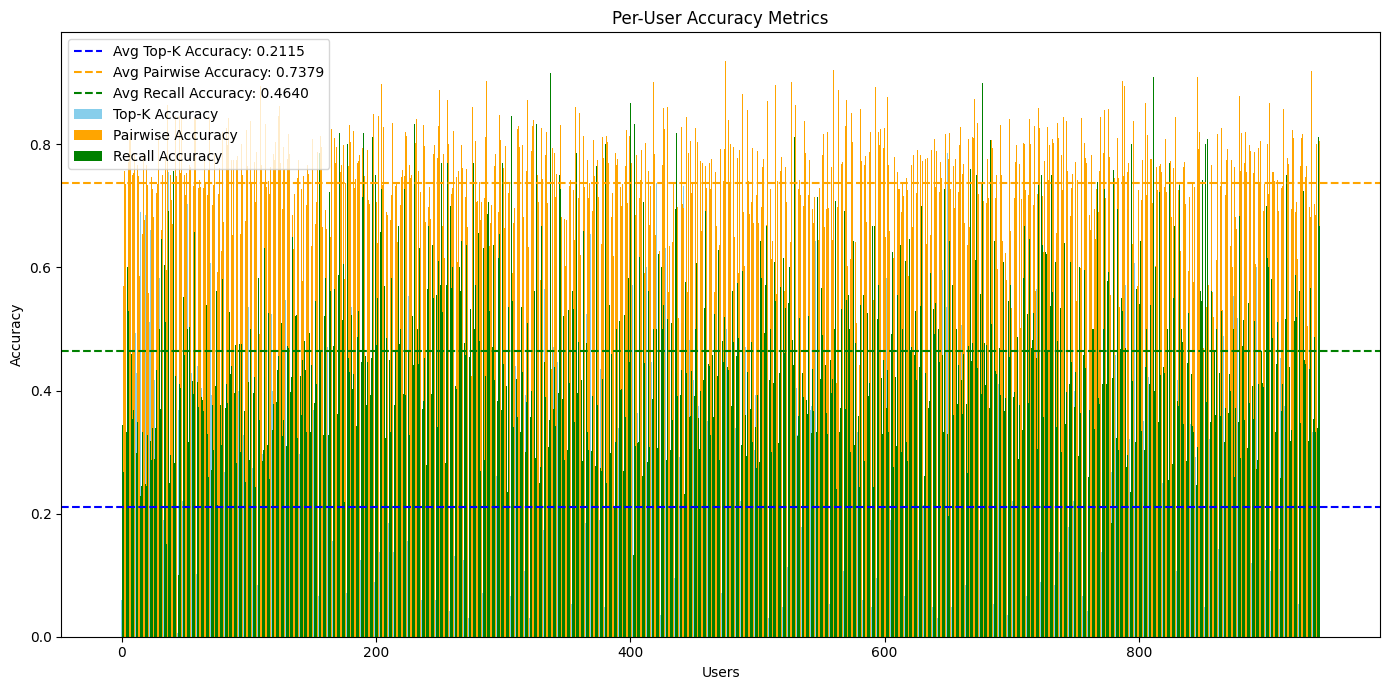

Average Top-K Accuracy: 0.2115
Average Pairwise Accuracy: 0.7379
Average Recall Accuracy: 0.4640


In [8]:
visualize_results(avg_top_k_accuracy3, avg_pair_accuracy3, avg_recall_accuracy3, results3)

In [9]:
save_result(avg_top_k_accuracy3, avg_pair_accuracy3, avg_recall_accuracy3, results3,"walk3data100k")

Results saved to evaluation_resultswalk3data100k.csv


In [10]:
avg_top_k_accuracy5, avg_pair_accuracy5,avg_recall_accuracy5 , results5 = evaluate_recommender(graph=user_movie_graph,
                                                                                           walk_length=5,
                                                                                           penalty_type="b",
                                                                                           k=10)

Working on: user_941

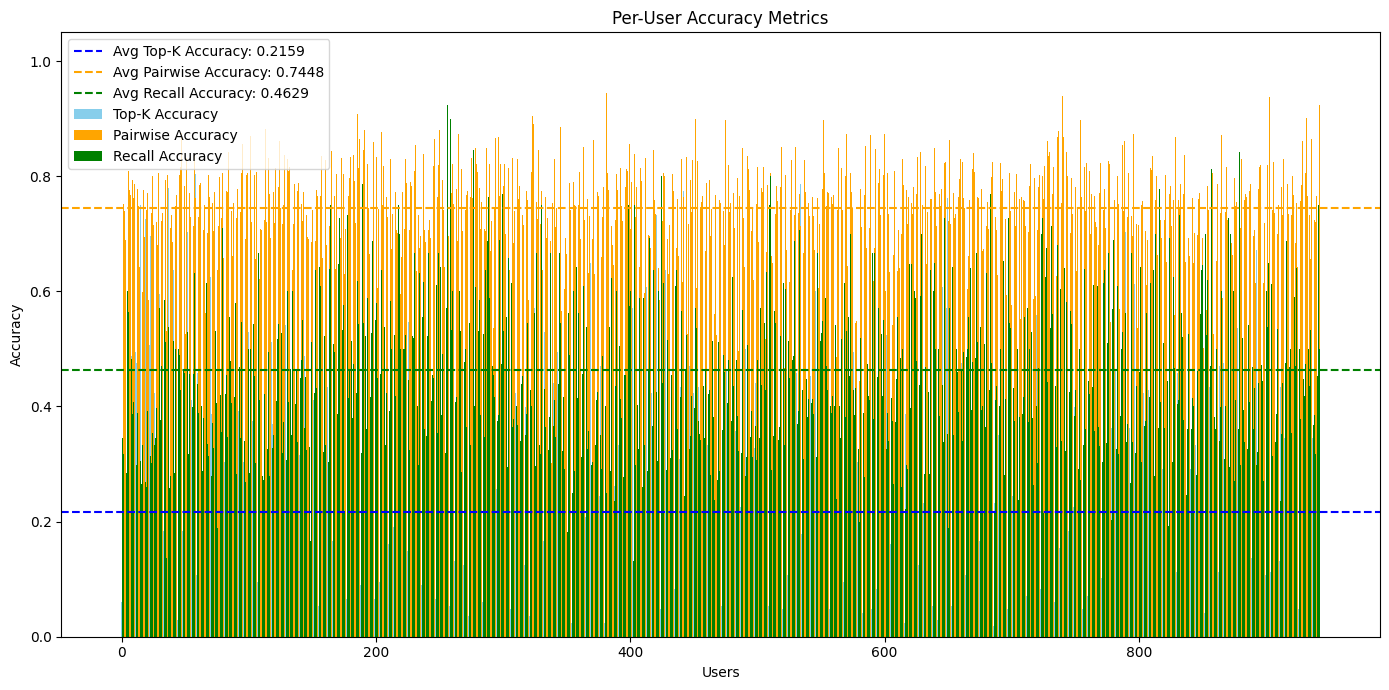

Average Top-K Accuracy: 0.2159
Average Pairwise Accuracy: 0.7448
Average Recall Accuracy: 0.4629


In [11]:
visualize_results(avg_top_k_accuracy5, avg_pair_accuracy5, avg_recall_accuracy5, results5)

In [12]:
save_result(avg_top_k_accuracy5, avg_pair_accuracy5, avg_recall_accuracy5, results5,"walk5data100k")

Results saved to evaluation_resultswalk5data100k.csv
